In [1]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

result_dir = '../results/classification'
metrics = pd.DataFrame(columns=['Maximum Sequence Length', 'Cutting Method', 'Number of Epochs', 'TP', 'FN', 'FP', 'TN'])

for mx in [4, 6, 8]:
    for cut in ['Before', 'After']:
        gt = pd.read_csv(f'{result_dir}/max{mx}_cut{cut}/gt_test_labels.csv')

        for epochs in [5, 15]:
            pred_files = [i for i in glob.glob(f'{result_dir}/max{mx}_cut{cut}/{epochs}epochs/*.csv')]
            pred = pd.concat([pd.read_csv(f) for f in pred_files])
            merged = pd.merge(gt, pred, left_on='Read ID', right_on='Read ID')

            cm = confusion_matrix(merged['GT Label'], merged['Predicted Label'])
            metrics = pd.concat([metrics, pd.DataFrame({
                'Maximum Sequence Length': [mx],
                'Cutting Method': [cut],
                'Number of Epochs': [epochs],
                'TP': [cm[0][0]],
                'TN': [cm[1][1]],
                'FP': [cm[0][1]], # len(merged[(merged['Predicted Label'] == 'plasmid') & (merged['GT Label'] == 'chr')])
                'FN': [cm[1][0]]})],
                ignore_index=True)

            cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Chromosome', 'Plasmid'])
            cm_display.plot()
            plt.title(f'Confusion Matrix of Plasmid Classification\n(max sequence length: {mx}k, cutted: {cut.lower()} normalization, epochs: {epochs})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig(f'../plots/max{mx}_cut{cut}_epochs{epochs}_confusion_matrix.png', dpi=300, facecolor='white')
            plt.close()

            #print(classification_report(merged['GT Label'], merged['Predicted Label']))

In [2]:
metrics['TPR'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])  # sensitivity/ recall
metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])  # specificity
metrics['FPR'] = metrics['FP'] / (metrics['FP'] + metrics['TN'])  # 1 - specificity
metrics['FNR'] = metrics['FN'] / (metrics['FN'] + metrics['TP'])

metrics['Precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
metrics['Accuracy'] = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
# -> Acc not suitable for imbalanced problems
metrics['F1S'] = metrics['TP'] / (metrics['TP'] + 0.5 * (metrics['FP'] + metrics['FN']))
# -> F1S is harmonic mean between precision & recall

In [3]:
metrics['ID'] = 'max' + metrics['Maximum Sequence Length'].astype(str) + '_cut' + metrics['Cutting Method'] + '_ep' + metrics['Number of Epochs'].astype(str)
metrics

,Maximum Sequence Length,Cutting Method,Number of Epochs,TP,FN,FP,TN,TPR,TNR,FPR,FNR,Precision,Accuracy,F1S,ID
0,4,Before,5,223390,16493,11,0,0.931246,0.0,1.0,0.068754,0.999951,0.931203,0.964376,max4_cutBefore_ep5
1,4,Before,15,223400,16493,1,0,0.931249,0.0,1.0,0.068751,0.999996,0.931245,0.964398,max4_cutBefore_ep15
2,4,After,5,223381,16491,20,2,0.931251,0.090909,0.909091,0.068749,0.99991,0.931174,0.96436,max4_cutAfter_ep5
3,4,After,15,223375,16485,26,8,0.931272,0.235294,0.764706,0.068728,0.999884,0.931174,0.964359,max4_cutAfter_ep15
4,6,Before,5,199419,15626,581,597,0.927336,0.506791,0.493209,0.072664,0.997095,0.925045,0.960951,max6_cutBefore_ep5
5,6,Before,15,198979,14712,1021,1511,0.931153,0.596761,0.403239,0.068847,0.994895,0.927237,0.961969,max6_cutBefore_ep15
6,6,After,5,199962,16206,38,17,0.925031,0.309091,0.690909,0.074969,0.99981,0.924874,0.960968,max6_cutAfter_ep5
7,6,After,15,199218,15300,782,923,0.928677,0.541349,0.458651,0.071323,0.99609,0.925623,0.961203,max6_cutAfter_ep15
8,8,Before,5,177925,14780,918,1191,0.923302,0.564723,0.435277,0.076698,0.994867,0.919421,0.95775,max8_cutBefore_ep5
9,8,Before,15,177348,13239,1495,2732,0.930536,0.646321,0.353679,0.069464,0.991641,0.924369,0.960117,max8_cutBefore_ep15


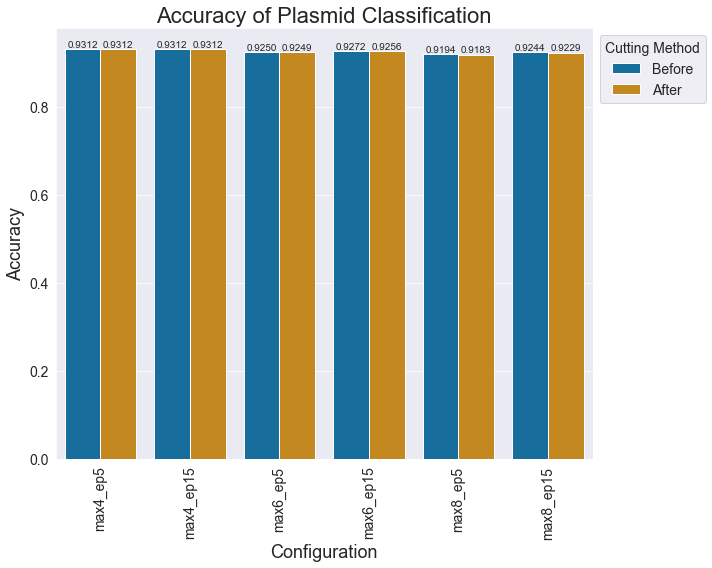

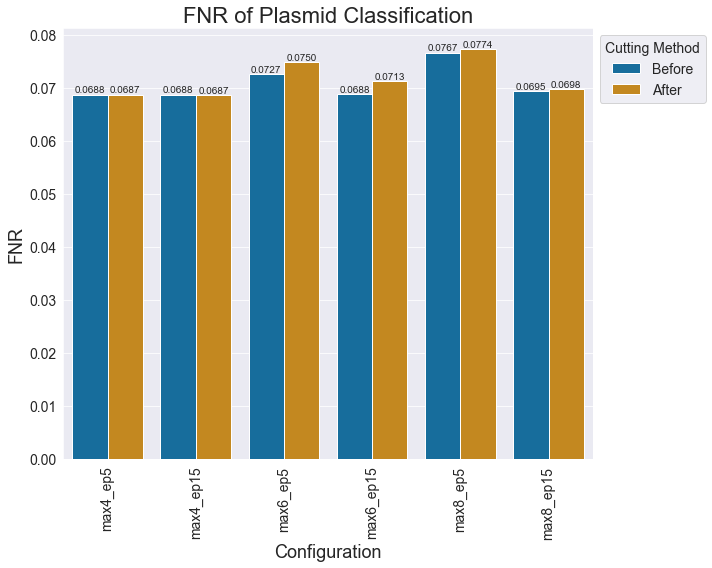

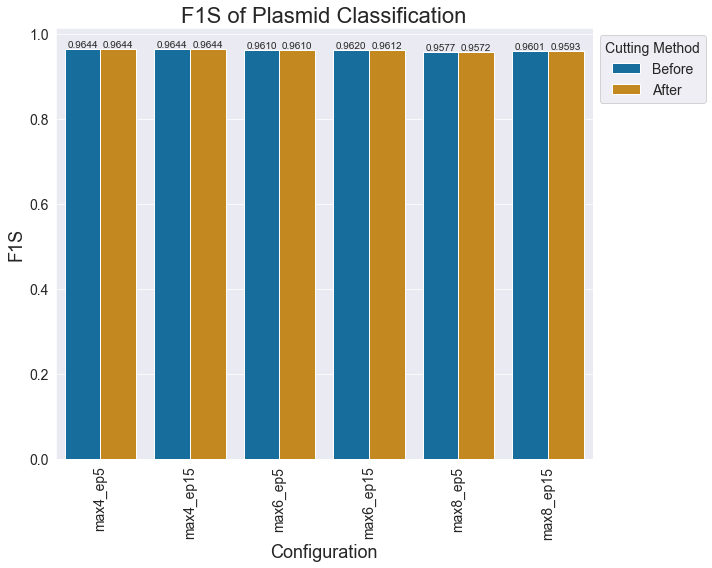

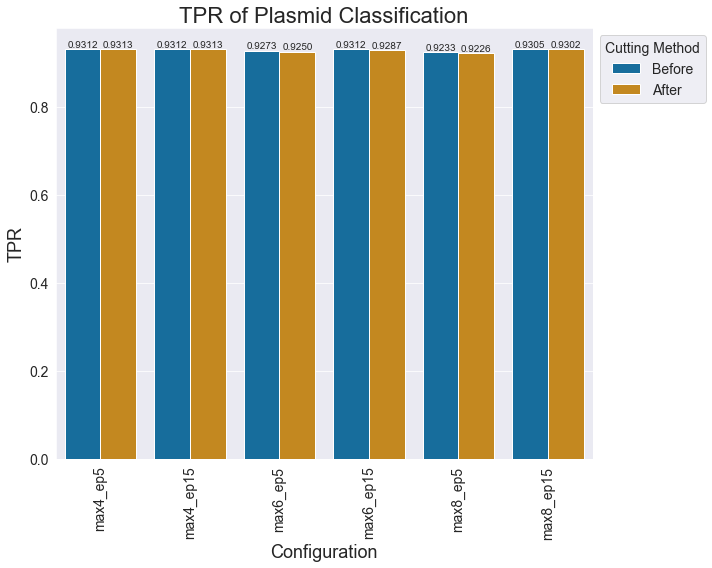

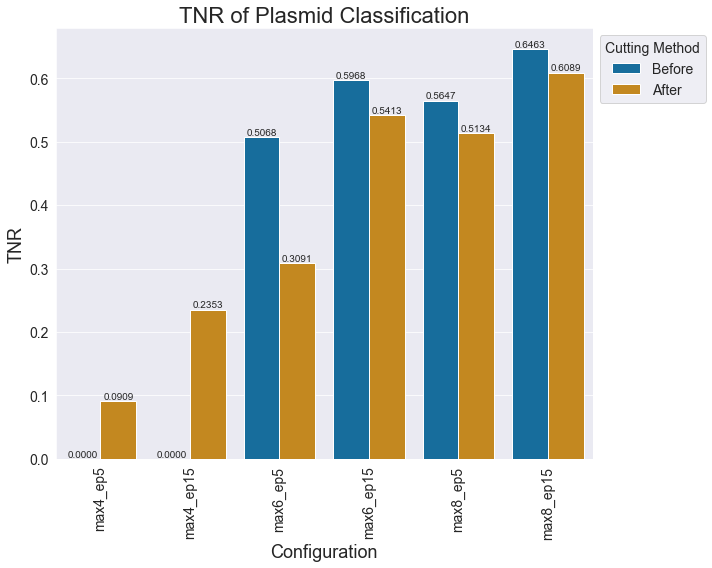

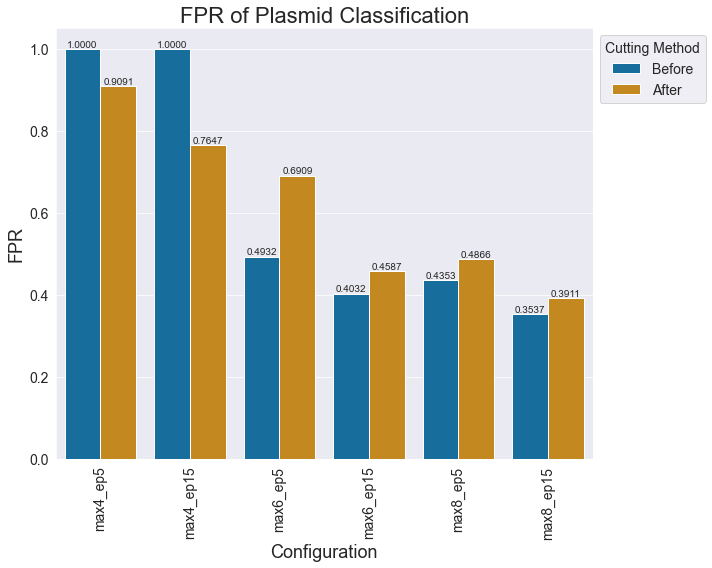

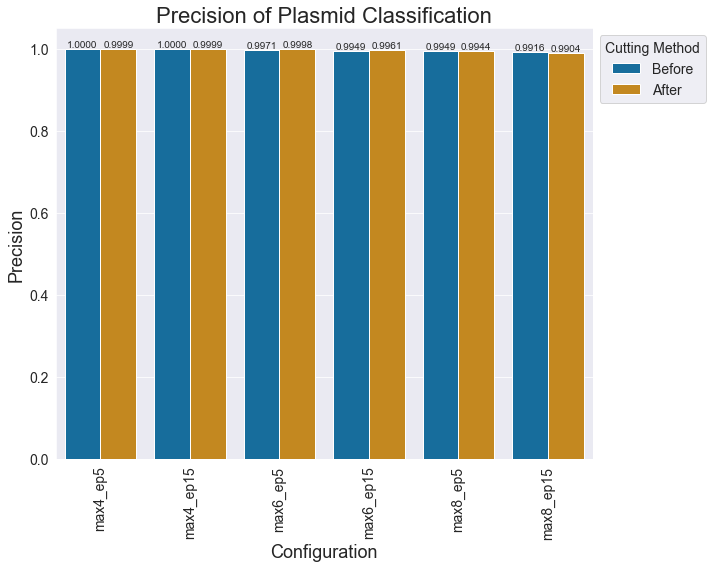

In [23]:
import seaborn as sns

plotdata = metrics.copy()
plotdata = plotdata.replace(['cutAfter_', 'cutBefore_'], ['', ''], regex=True)

for metric in ['Accuracy', 'FNR', 'F1S', 'TPR', 'TNR', 'FPR', 'Precision']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=plotdata,
                x='ID',
                y=metric,
                hue='Cutting Method',
                palette=sns.color_palette('colorblind'))

    # place y-values above bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')

    plt.title(f'{metric} of Plasmid Classification', fontsize=22)
    plt.xlabel('Configuration', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(title='Cutting Method', fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig(f'../plots/{metric}.png', dpi=300, facecolor='white')
    #plt.close()

In [5]:
# TODO: roc auc / tpr vs. fpr?
# TODO: several metrics in one plot?

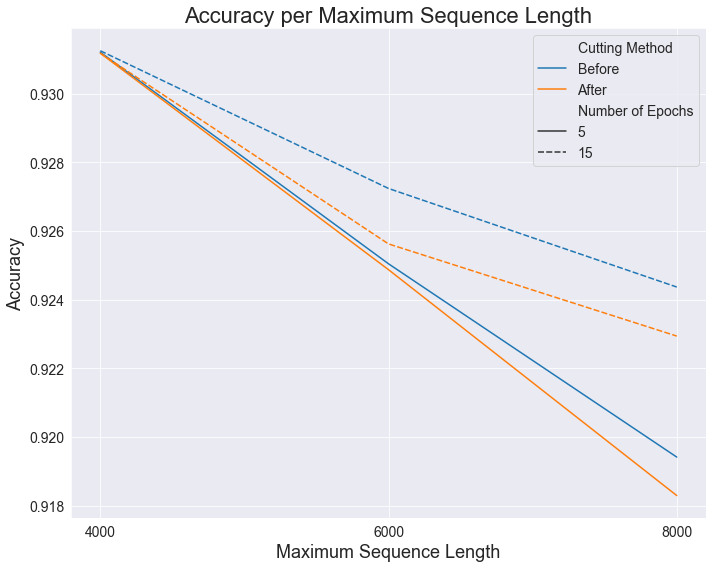

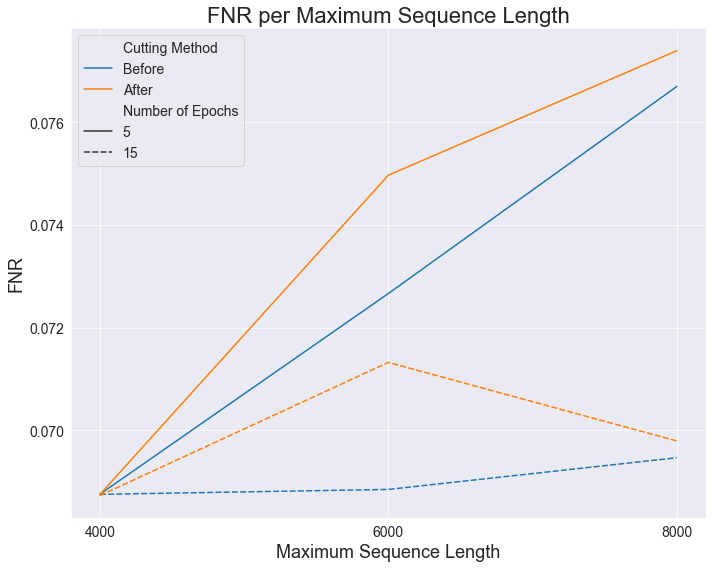

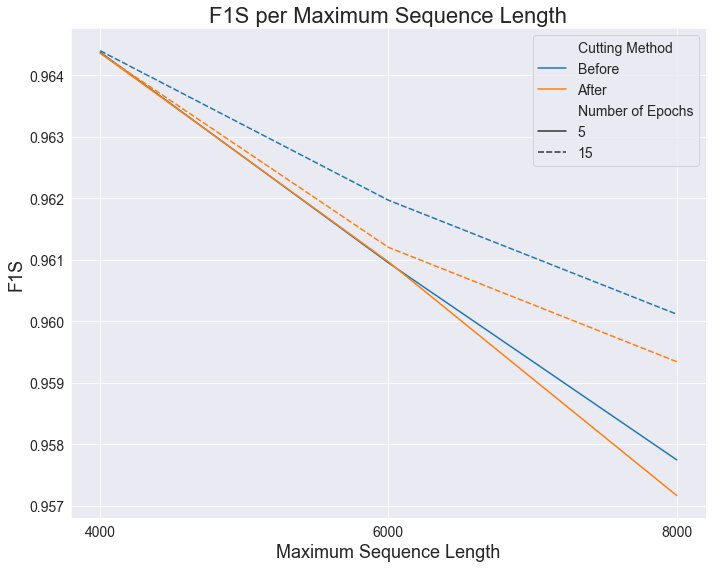

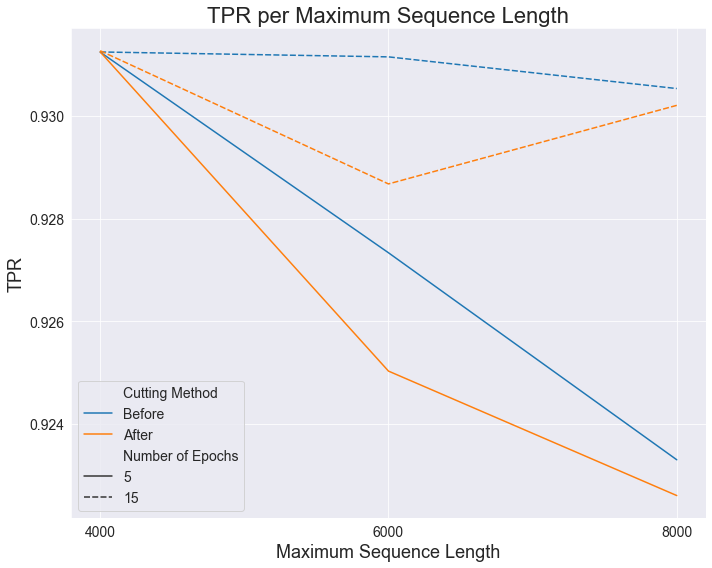

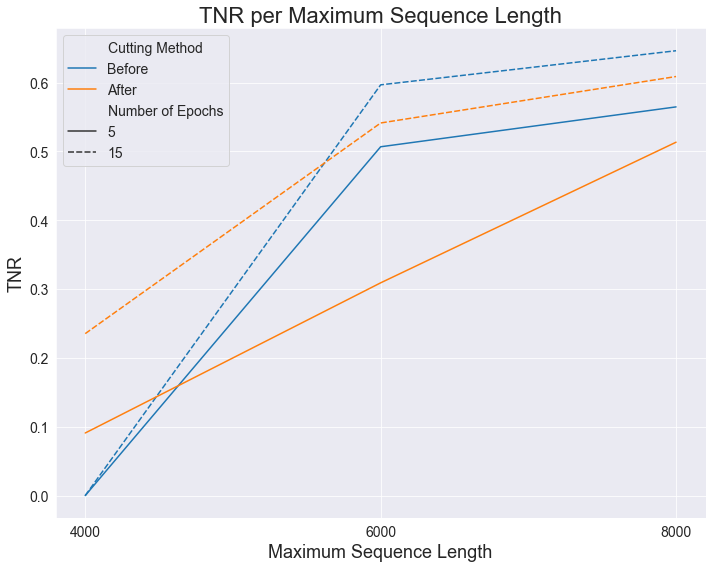

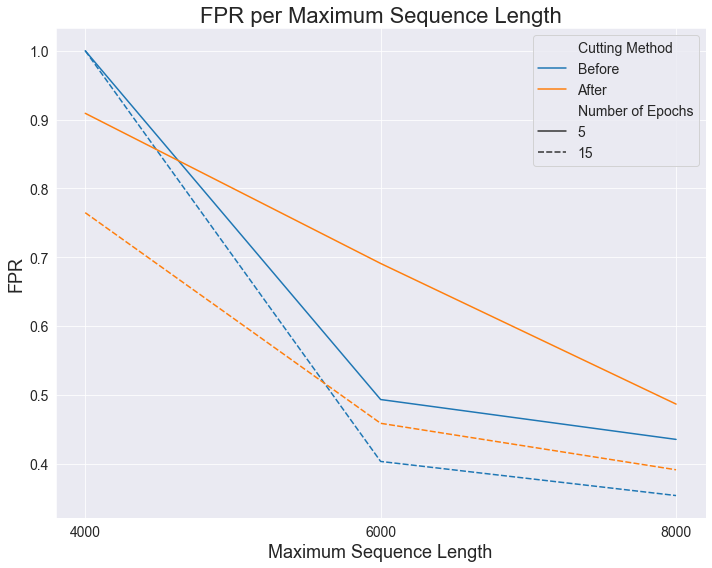

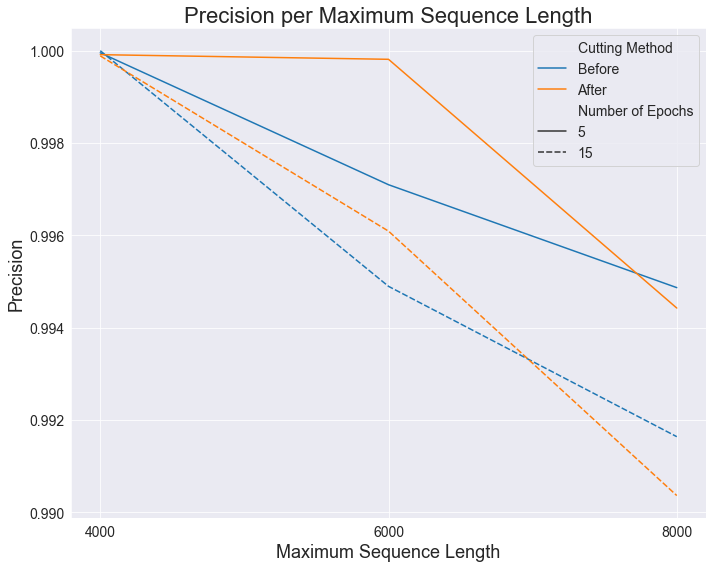

In [22]:
import seaborn as sns

plotdata = metrics.copy()
for metric in ['Accuracy', 'FNR', 'F1S', 'TPR', 'TNR', 'FPR', 'Precision']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.lineplot(data=plotdata,
                 x='Maximum Sequence Length',
                 y=metric,
                 hue='Cutting Method',
                 style='Number of Epochs')

    plt.title(f'{metric} per Maximum Sequence Length', fontsize=22)
    plt.xlabel('Maximum Sequence Length', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(fontsize=14, ticks=plotdata['Maximum Sequence Length'], labels=plotdata['Maximum Sequence Length'].astype(str) + '000')
    plt.locator_params(axis='x', nbins=3)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.savefig(f'../plots/{metric}_per_max.png', dpi=300, facecolor='white')
    #plt.close()